# Text Prediction - Quick Start

In this quick start, we will introduce the `TextPrediction` task in AutoGluon, which helps you solve solve NLP problems automatically.

The `TextPrediction` functionality depends on the [GluonNLP](https://gluon-nlp.mxnet.io/) package. 
Due to the ongoing upgrade of GluonNLP, we are currently using a customized version in [autogluon-contrib-nlp](https://github.com/sxjscience/autogluon-contrib-nlp.git). In a future release, we will switch to use the official GluonNLP.

In this example, we use two examples to show how to use `TextPrediction` to solve different types of NLP tasks, including:
- [Sentiment Analysis](#Sentiment-Analysis)
- [Sentence Similarity](#Sentence-Similarity)

The general usage is similar to AutoGluon-Tabular, we load the one dataset as a table and specify that certain column is the label column. Here, the label can not only be **categorical** but also **numerical**. Internally, we build the network based on pretrained NLP models including [BERT](https://arxiv.org/pdf/1810.04805.pdf), [ALBERT](https://arxiv.org/pdf/1909.11942.pdf), and [ELECTRA](https://openreview.net/pdf?id=r1xMH1BtvB). In addition, we run multiple trials with different hyper-parameters and return the best model. The searching logic is powered by the prebuilt Hyper-Parameter Optimization (HPO) algorithm.

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Sentiment Analysis

First, we use the Stanford Sentiment Treebank ([SST](https://nlp.stanford.edu/sentiment/)).
The dataset consists movie reviews and their sentiment. We will need to predict the correct sentiment. It's a **binary classification** problem. Let's first load the data and view some examples.

In [2]:
from autogluon.utils.tabular.utils.loaders import load_pd
train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet')
dev_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet')
train_data.head(10)

rand_idx = np.random.permutation(np.arange(len(train_data)))[:2000]
train_data = train_data.iloc[rand_idx]

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet | Columns = 2 / 2 | Rows = 67349 -> 67349
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet | Columns = 2 / 2 | Rows = 872 -> 872


For this example, we simply call `.fit()` with a random of 2000 training samples. Each trial is trained for at most 30 seconds using `.fit()` and we will just use 4 trials.

2020-08-02 08:19:21,673 - root - INFO - All Logs will be saved to ./ag_sst/ag_text_prediction.log
2020-08-02 08:19:21,686 - root - INFO - Train Dataset:
2020-08-02 08:19:21,687 - root - INFO - Columns:

- Text(
   name="sentence"
   #total/missing=1700/0
   length, min/avg/max=4/51.81/251
)
- Categorical(
   name="label"
   #total/missing=1700/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[726, 974]
)


2020-08-02 08:19:21,687 - root - INFO - Tuning Dataset:
2020-08-02 08:19:21,688 - root - INFO - Columns:

- Text(
   name="sentence"
   #total/missing=300/0
   length, min/avg/max=5/56.84/259
)
- Categorical(
   name="label"
   #total/missing=300/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[155, 145]
)


2020-08-02 08:19:21,688 - root - INFO - Label columns=['label'], Problem types=['classification'], Label shapes=[2]
2020-08-02 08:19:21,689 - root - INFO - Eval Metric=acc, Stop Metric=acc, Log Metrics=['f1', 'mcc', 'auc', 'acc', 'nll']
2020

100%|██████████| 212/212 [00:26<00:00,  7.99it/s]


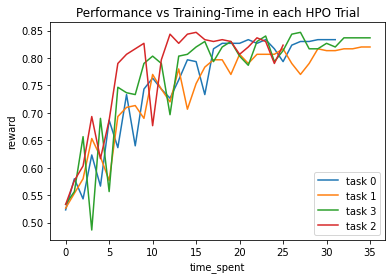

In [3]:
from autogluon import TextPrediction as task

predictor = task.fit(train_data, label='label', time_limits=30,
                     ngpus_per_trial=1, seed=123,
                     output_directory='./ag_sst')

Next, you can use `predictor.evaluate()` to evaluate the model on the dev set.

In [4]:
dev_score = predictor.evaluate(dev_data, metrics='acc')
print('Best Config = {}'.format(predictor.results['best_config']))
print('Total Time = {}s'.format(predictor.results['total_time']))
print('Accuracy = {:.2f}'.format(dev_score['acc']))

Best Config = {'search_space▁optimization.lr': 7.830440237877588e-05}
Total Time = 33.04304027557373s
Accuracy = 0.83


To get the prediction, use `predictor.predict()`.

In [5]:
import pandas as pd
sentence1 = "it's a charming and often affecting journey." 
sentence2 = "It's slow, very, very, very slow."
predictions = predictor.predict(pd.DataFrame({'sentence': [sentence1, sentence2]}))
print('"Sentence":', sentence1, '"Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Sentiment":', predictions[1])


"Sentence": it's a charming and often affecting journey. "Sentiment": 1
"Sentence": It's slow, very, very, very slow. "Sentiment": 0


For classification tasks, you can also choose to output the probability of each class via `predictor.predict_proba()`.

In [6]:
import pandas as pd
probs = predictor.predict_proba(pd.DataFrame({'sentence': [sentence1, sentence2]}))
print('"Sentence":', sentence1, '"Sentiment":', probs[0])
print('"Sentence":', sentence2, '"Sentiment":', probs[1])

"Sentence": it's a charming and often affecting journey. "Sentiment": [8.0074073e-04 9.9919933e-01]
"Sentence": It's slow, very, very, very slow. "Sentiment": [0.90542376 0.09457624]


## Sentence Similarity

Here, let's see how to use AutoGluon to train a model for evaluating the similarity between two sentences. We use the [Semantic Textual Similarity Benchmark](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) for illustration.

In [7]:
train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/train.parquet')[['sentence1', 'sentence2', 'score']]
dev_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/dev.parquet')[['sentence1', 'sentence2', 'score']]
train_data.head(10)

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
5,Some men are fighting.,Two men are fighting.,4.25
6,A man is smoking.,A man is skating.,0.50
7,The man is playing the piano.,The man is playing the guitar.,1.60
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.20
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.00


2020-08-02 08:19:59,784 - root - INFO - All Logs will be saved to ./ag_sts/ag_text_prediction.log
2020-08-02 08:19:59,798 - root - INFO - Train Dataset:
2020-08-02 08:19:59,798 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=4886/0
   length, min/avg/max=16/57.66/367
)
- Text(
   name="sentence2"
   #total/missing=4886/0
   length, min/avg/max=15/57.43/311
)
- Numerical(
   name="score"
   #total/missing=4886/0
   shape=()
)


2020-08-02 08:19:59,799 - root - INFO - Tuning Dataset:
2020-08-02 08:19:59,799 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=863/0
   length, min/avg/max=16/58.00/227
)
- Text(
   name="sentence2"
   #total/missing=863/0
   length, min/avg/max=16/58.13/212
)
- Numerical(
   name="score"
   #total/missing=863/0
   shape=()
)


2020-08-02 08:19:59,799 - root - INFO - Label columns=['score'], Problem types=['regression'], Label shapes=[()]
2020-08-02 08:19:59,800 - root - INFO - Eval Metric=mse, Stop Metric=mse, Log

 65%|██████▌   | 399/612 [01:02<00:33,  6.43it/s]


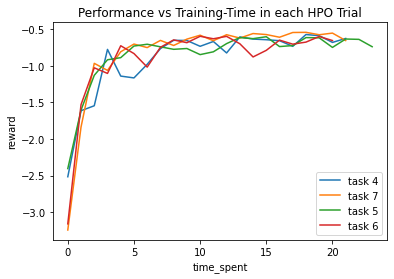

In [8]:
predictor_sts = task.fit(train_data, label='score',
                         time_limits=60, ngpus_per_trial=1, seed=123,
                         output_directory='./ag_sts')

In [9]:
dev_score = predictor_sts.evaluate(dev_data, metrics=['rmse', 'pearsonr', 'spearmanr'])
print('Best Config = {}'.format(predictor_sts.results['best_config']))
print('Total Time = {}s'.format(predictor_sts.results['total_time']))
print('RMSE = {:.2f}'.format(dev_score['rmse']))
print('PEARSONR = {:.4f}'.format(dev_score['pearsonr']))
print('SPEARMANR = {:.4f}'.format(dev_score['spearmanr']))

Best Config = {'search_space▁optimization.lr': 5.5e-05}
Total Time = 69.03160190582275s
RMSE = 0.79
PEARSONR = 0.8548
SPEARMANR = 0.8538


In [10]:
score1 = predictor_sts.predict({'sentence1': ['A young child is riding a horse.'],
                                'sentence2': ['A child is riding a horse.']})

score2 = predictor_sts.predict({'sentence1': ['A young child is riding a horse.'],
                                'sentence2': ['A young man is riding a horse.']})

score3 = predictor_sts.predict({'sentence1': ['A young child is riding a horse.'],
                                'sentence2': ['A young woman is riding a horse.']})

score4 = predictor_sts.predict({'sentence1': ['A young child is riding a horse.'],
                                'sentence2': ['A woman is riding a horse.']})
print(score1, score2, score3, score4)

[4.257054] [3.0778303] [2.4763744] [1.726313]
